# 🧠 Non-Linear Parameter Estimation using Python
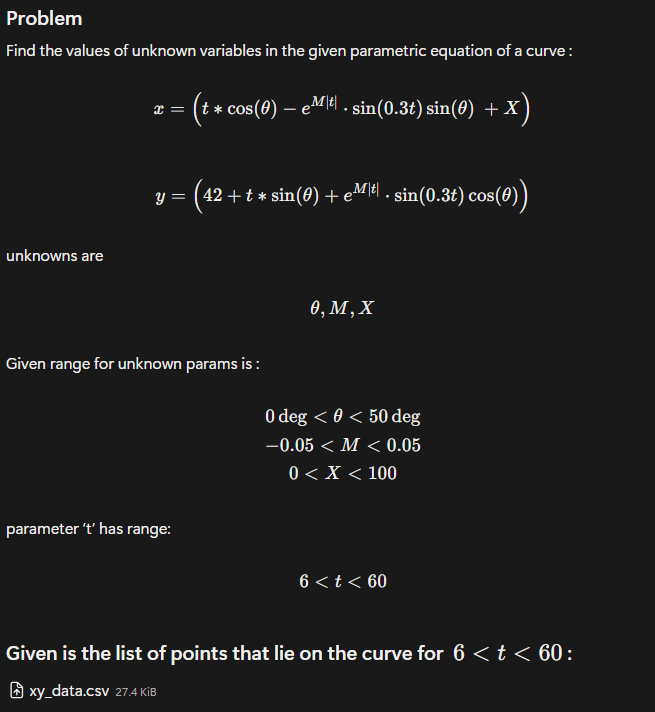


This notebook performs non-linear curve fitting using numerical optimization to estimate the parameters θ, M, and X that best fit the given (x, y) data.

It also visualizes the fitted curve versus the observed data.

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# 1️⃣ Load your data (update path if needed)

data = pd.read_csv("xy_data.csv")
x_data = data.iloc[:, 0].values
y_data = data.iloc[:, 1].values
print(f"Loaded {len(x_data)} data points.")


Loaded 1500 data points.


In [2]:
# 2️⃣ Define the objective function

def objective_function(params, x_data, y_data):
    theta_rad, M, X = params
    cos_t, sin_t = np.cos(theta_rad), np.sin(theta_rad)

    # Inverse transform (x, y) → (u, v)
    x_prime = x_data - X
    y_prime = y_data - 42
    u = x_prime * cos_t + y_prime * sin_t
    v = -x_prime * sin_t + y_prime * cos_t

    v_pred = np.exp(np.clip(M * np.abs(u), -10, 10)) * np.sin(0.3 * u)

    # Return mean squared error
    return np.mean((v - v_pred) ** 2)


In [3]:


# 3️⃣ Run the optimization

max_theta_rad = 50 * np.pi / 180
bounds = [(1e-6, max_theta_rad - 1e-6), (-0.05, 0.05), (0, 100)]
initial_guess = [max_theta_rad / 2, 0.0, 50.0]

print("Starting optimization... ⏳")
result = minimize(
    objective_function,
    initial_guess,
    args=(x_data, y_data),
    method="L-BFGS-B",
    bounds=bounds,
    options={"disp": True}
)


Starting optimization... ⏳


/tmp/ipython-input-4085602422.py:9: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result = minimize(


In [4]:

# 4️⃣ Display fitted parameters

theta_rad_opt, M_opt, X_opt = result.x
theta_deg_opt = np.degrees(theta_rad_opt)
print("\n✅ Optimization Successful!")
print(f"Theta (deg): {theta_deg_opt:.4f}")
print(f"M:           {M_opt:.6f}")
print(f"X:           {X_opt:.6f}")
print(f"MSE:         {result.fun:.8f}")

results = pd.DataFrame({
    "Parameter": ["Theta (deg)", "M", "X", "Mean Squared Error"],
    "Value": [theta_deg_opt, M_opt, X_opt, result.fun]
})
results.to_csv("fit_results.csv", index=False)
print("✅ Results saved to fit_results.csv")



✅ Optimization Successful!
Theta (deg): 30.0000
M:           0.030000
X:           54.999999
MSE:         0.00000000
✅ Results saved to fit_results.csv


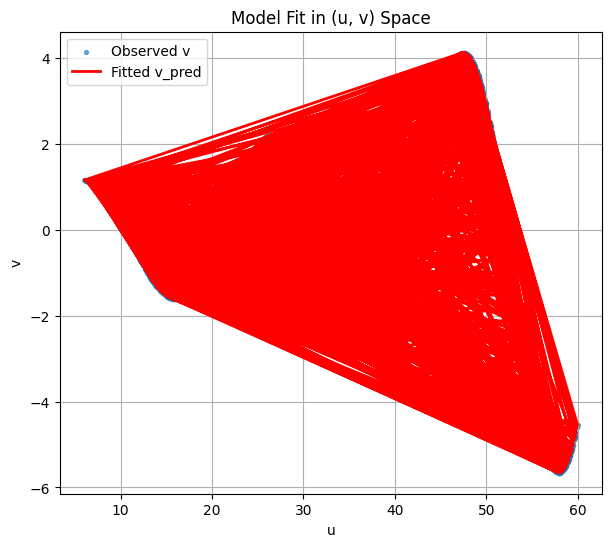

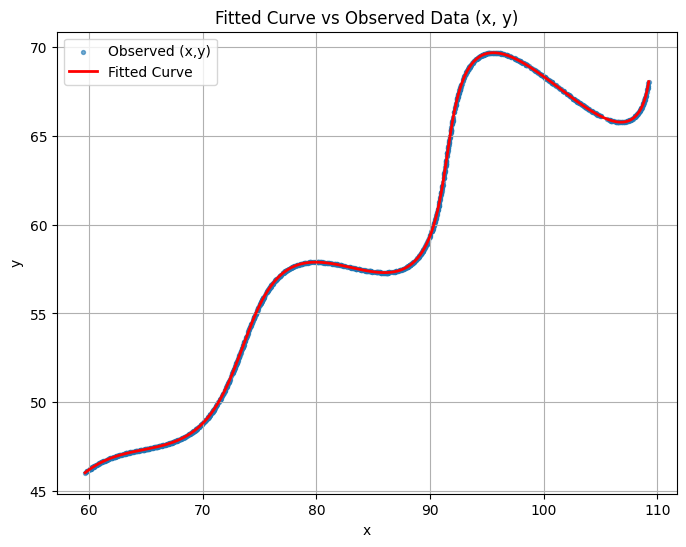

In [5]:

# 5️⃣ Plot fitted data in (u, v) and (x, y)

cos_t, sin_t = np.cos(theta_rad_opt), np.sin(theta_rad_opt)
x_prime = x_data - X_opt
y_prime = y_data - 42
u = x_prime * cos_t + y_prime * sin_t
v = -x_prime * sin_t + y_prime * cos_t
v_pred = np.exp(np.clip(M_opt * np.abs(u), -10, 10)) * np.sin(0.3 * u)

# Plot in (u, v) space
plt.figure(figsize=(7, 6))
plt.scatter(u, v, s=8, label="Observed v", alpha=0.6)
plt.plot(u, v_pred, color="red", linewidth=2, label="Fitted v_pred")
plt.xlabel("u")
plt.ylabel("v")
plt.title("Model Fit in (u, v) Space")
plt.legend()
plt.grid(True)
plt.show()

# Plot in (x, y) space
u_curve = np.linspace(min(u), max(u), 400)
v_curve = np.exp(np.clip(M_opt * np.abs(u_curve), -10, 10)) * np.sin(0.3 * u_curve)
x_curve = X_opt + (u_curve * cos_t - v_curve * sin_t)
y_curve = 42 + (u_curve * sin_t + v_curve * cos_t)

plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data, s=8, label="Observed (x,y)", alpha=0.6)
plt.plot(x_curve, y_curve, color="red", linewidth=2, label="Fitted Curve")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Fitted Curve vs Observed Data (x, y)")
plt.legend()
plt.grid(True)
plt.show()


#R-squared Error


In [6]:
# Calculate R-squared error
# R-squared = 1 - (SSE / SST)
# SSE = sum of squared errors
# SST = total sum of squares

ss_total = np.sum((v - np.mean(v)) ** 2)
ss_residual = np.sum((v - v_pred) ** 2)
r_squared = 1 - (ss_residual / ss_total)

print(f"R-squared: {r_squared:.6f}")

R-squared: 1.000000


In [7]:
ss_total

np.float64(8757.3187580062)

In [8]:
ss_residual

np.float64(1.8979059116834262e-08)

#


#Calculate the L1 distance between uniformly sampled points between expected and predicted curve.

In [9]:
u_curve = np.linspace(min(u), max(u), 400)
v_curve = np.exp(np.clip(M_opt * np.abs(u_curve), -10, 10)) * np.sin(0.3 * u_curve)

# Inverse rotation + translation
x_curve = X_opt + (u_curve * cos_t - v_curve * sin_t)
y_curve = 42 + (u_curve * sin_t + v_curve * cos_t)

fitted_curve_points = np.column_stack((x_curve, y_curve))

In [10]:
def expected_curve_function(u, M):
    return np.exp(np.clip(M * np.abs(u), -10, 10)) * np.sin(0.3 * u)
u_expected = np.linspace(min(u), max(u), 400)
v_expected = expected_curve_function(u_expected, M_opt)

# Inverse rotation + translation to get the (x, y) coordinates in the original space.
x_expected = X_opt + (u_expected * cos_t - v_expected * sin_t)
y_expected = 42 + (u_expected * sin_t + v_expected * cos_t)

# Store these generated points as a set of points representing the expected curve.
expected_curve_points = np.column_stack((x_expected, y_expected))

In [11]:

abs_diff_x = np.abs(fitted_curve_points[:, 0] - expected_curve_points[:, 0])
abs_diff_y = np.abs(fitted_curve_points[:, 1] - expected_curve_points[:, 1])
sum_abs_diff_x = np.sum(abs_diff_x)
sum_abs_diff_y = np.sum(abs_diff_y)

l1_distance = sum_abs_diff_x + sum_abs_diff_y

print(f"L1 Distance between fitted and expected curves: {l1_distance:.6f}")

L1 Distance between fitted and expected curves: 0.000000


In [12]:
print(f"L1 Distance: {l1_distance}")

L1 Distance: 0.0
